In [4]:
import numpy as np
import matplotlib.pyplot as plt

import qiskit
from qiskit               import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, execute, Aer
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator
from qiskit.visualization import plot_histogram

from qiskit.opflow.state_fns    import CircuitStateFn
from qiskit.opflow              import PauliSumOp
from qiskit.quantum_info        import SparsePauliOp

from qiskit.quantum_info.operators import Operator, Pauli, SparsePauliOp
from qiskit.opflow import I, X, Y, Z, One, Zero


def H_ising(num_qubits,J,b):
    m=num_qubits-1
    n=num_qubits-2
    G=b*((I^m)^X)
    H=0
    hamiltonian1=H
    hamiltonian2=G
    
    for i in range(n+1):
        H =(I^i)^Z^Z^(I^(n-i))
        G=(I^i)^X^(I^(m-i))
        hamiltonian1=hamiltonian1+J*H
        hamiltonian2=hamiltonian2+b*G
    
    hamiltonian=hamiltonian1+hamiltonian2
    return hamiltonian

In [5]:
def U_ising(num_qubits,J,b,t):
    # Compute Ising Hamiltonian 
    H = H_ising(num_qubits,J,b)
    
    # Return the exponential of -i multipled by time t multipled by the Ising Hamiltonian 
    return (t * H).exp_i()

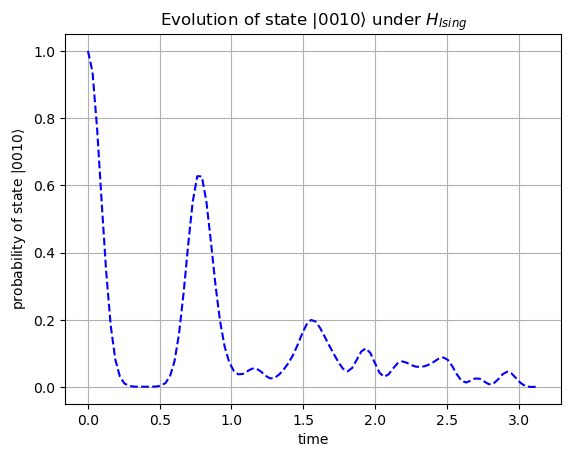

In [10]:
# Define array of time points
ts      = np.linspace(0, np.pi, 100)
num_qubits=4
J=-1
b=4

# Define initial state 
initial_state = Zero^One^Zero^Zero

# Compute probability of remaining in |110> state over the array of time points
 # ~initial_state gives the bra of the initial state (<110|)
 # @ is short hand for matrix multiplication
 # U_ising(t) is the unitary time evolution at time t
 # t needs to be wrapped with float(t) to avoid a bug
 # (...).eval() returns the inner product <0010|U_ising(t)|>
 #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value,
 # or probability, of remaining in |110>
probs_0010_exact = [np.abs((~initial_state @ U_ising(num_qubits,J,b,float(t)) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |0010>
plt.plot(ts, probs_0010_exact,linestyle="dashed",color="blue")
plt.xlabel('time')
plt.ylabel(r'probability of state $|0010\rangle$')
plt.title(r'Evolution of state $|0010\rangle$ under $H_{Ising}$')
plt.grid()
plt.show()

In [21]:
## Here we introduce a general function for Heisenberg chain Trotter evolution
## The circuit will not contain the initialisation

def Ising_Trotter(num_qubits,J,b,trotter_steps,t):
    
    '''
    Circuit implementing Trotterization of the time evolutiom operator for the XXX Heisenberg
    model on num_spins.
    
    Naively, every  Trotter step requires 6*(num_spins-1) CNOTs
    
    Args:
        - num_spins: int, number of qubits of the system
        - trotter_steps: the number of trotter steps n to implement
        - t: the simulation time we are targeting
        
    Returns:
        A QuantumCircuit implementing the Trotterization of the time evolutiom operator for the XXX Heisenberg
        model
    '''
    
    # Given a target time and a number of Trotter steps, every step will evolve the 
    # circuit for a time step dt = target_time/trotter_steps
    dt = t/trotter_steps

    # Initialize quantum circuit for n_spins
    qr = QuantumRegister(num_qubits)
    # A QuantumCircuit can also be initialised without a classical register (in this case classical bits == qubits)
    qc = QuantumCircuit(qr) 
    
    for _ in range(trotter_steps):
        for i in range(0, num_qubits - 1):
            qc.rzz(J*2*dt,i,i+1)
            qc.rx(b*2*dt,i)
        qc.rx(b*2*dt,num_qubits-1)
        
        # To separate the different Trotter steps
        qc.barrier()


    return qc

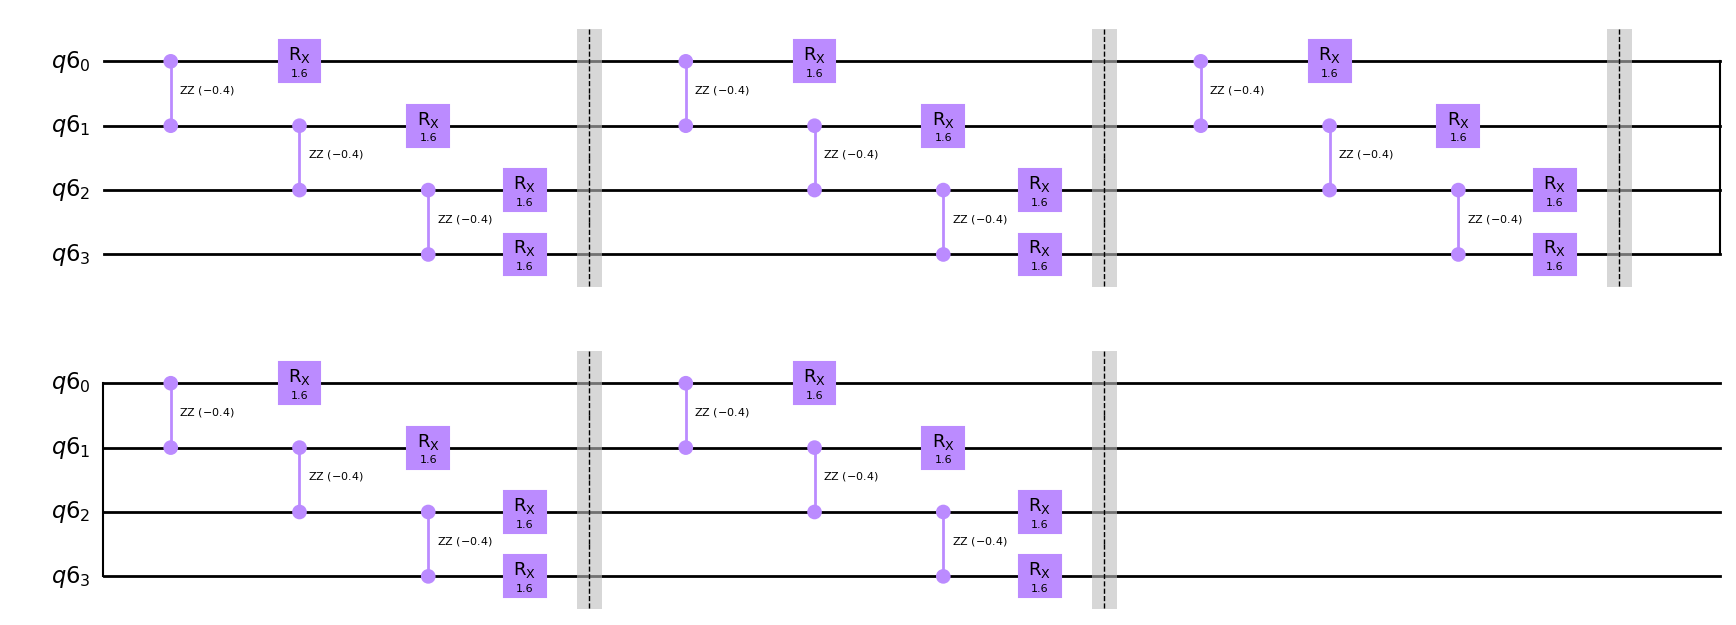

In [23]:
Ising_Trotter(4,-1,4,5,1).draw('mpl')

In [34]:
from qiskit.opflow.state_fns    import CircuitStateFn
from qiskit.opflow.expectations import PauliExpectation
from qiskit.utils               import QuantumInstance
from qiskit.opflow              import CircuitSampler, StateFn
# Simulate the system with a different number of Trotter steps and compare with the matrix exponentiation
# In this case, we will consider 4, 8 and 12 Trotter steps

probs_0010_trott = {4:[],8:[],20:[]}

## Define where you want to run the circuit
backend     = Aer.get_backend("statevector_simulator")             # Exact
#backend     = QasmSimulator(shots=8000)                           # Shots
#backend     = QasmSimulator(noise_model=noise_model, shots= 8000) # Noisy

expectation = PauliExpectation() 
sampler     = CircuitSampler(backend)

## We want to measure |110><110|
prj = StateFn((1/16)*(I+Z)^(I-Z)^(I+Z)^(I+Z),is_measurement=True)

# We loop over different number of Trotter steps
for n in probs_0010_trott.keys():
    for sim_t in ts:
        # Initialize the circuit
        trott_qr = QuantumRegister(4)
        trott_qc = QuantumCircuit(trott_qr)
        trott_qc.x(2)
    
        # Append the Trotterization
        trott_steps = Ising_Trotter(num_qubits=4,J=-1,b=4,trotter_steps=n,t=sim_t)
        #trott_qc   = trott_qc.compose(trott_steps)
        trott_qc.append(trott_steps, [trott_qr[0], trott_qr[1], trott_qr[2], trott_qr[3]])
        
        trott_expect  = expectation.convert(prj @ StateFn(trott_qc))
        trott_sample  = sampler.convert(trott_expect)
        probs_0010_trott[n].append(trott_sample.eval().real)

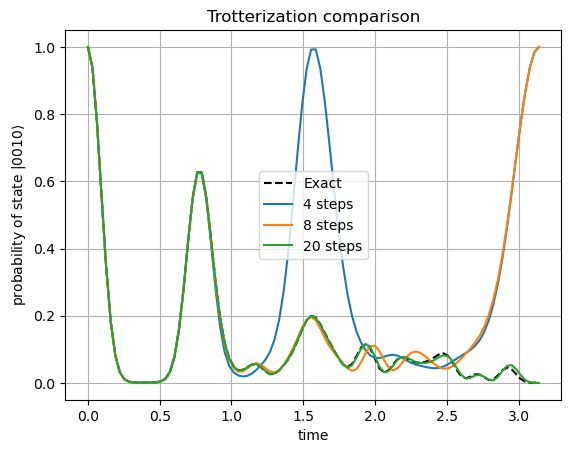

In [35]:
# Now plot the comparison
plt.plot(ts, probs_0010_exact,linestyle="dashed",color="black",label="Exact")
for (i,n) in enumerate(probs_110_trott.keys()):
    plt.plot(ts, probs_0010_trott[n],color="C"+str(i),label=str(n)+" steps")
plt.xlabel('time')
plt.ylabel(r'probability of state $|0010\rangle$')
plt.title(r'Trotterization comparison')
plt.legend()
plt.grid()
plt.show()

In [56]:
import math
import numpy as np
from numpy import linalg
from scipy.linalg import expm

J = 1
c_times = np.linspace(0,0.5*math.pi/abs(J),1000)
q_times = np.linspace(0,0.5*math.pi/abs(J),10)

### Classical simulation of the Heisenberg dimer model

##preparation of physical quantity - Single qubit operators

sx = np.array([[0.0, 1.0],[1.0, 0.0]])
sy = np.array([[0.0, -1.0*1j],[1.0*1j, 0.0]])
sz = np.array([[1.0, 0.0],[0.0, -1.0]])
idt = np.array([[1.0, 0.0],[0.0, 1.0]])

### initial state definition and execution

#psi0 = np.kron( np.array([0,1]), np.array([1,0]), np.array([0,1]), np.array([1,0]) )

psi0=Zero^One^Zero^Zero


#H = J * ( np.kron(sz,sz,idt,idt)+np.kron(idt,idt,sz,sz)+np.kron(idt,sz,sz,idt))+\
   #b*(np.kron(sx,idt,idt,idt)+np.kron(idt,sx,idt,idt)+np.kron(idt,idt,sx,idt)+np.kron(idt,idt,idt,sx))

sz1_t = np.zeros(len(c_times))
sz2_t = np.zeros(len(c_times))
sz3_t = np.zeros(len(c_times))
sz4_t = np.zeros(len(c_times))
sz=np.zeros(len(c_times))

sz1 = I^I^I^Z#np.kron(sz,idt,idt,idt)
sz2 = I^I^Z^I#np.kron(idt,sz,idt,idt)
sz3 = I^Z^I^I#np.kron(idt,idt,sz,idt)
sz4 = Z^I^I^I#np.kron(idt,idt,idt,sz)

for i in range(len(c_times)):
    
    t = c_times[i]
    psi_t = U_ising(num_qubits,J,b,float(t)) @ psi0
    sz1_t[i] = np.real((~psi_t @ sz1 @ psi_t).eval())
    sz2_t[i] = np.real((~psi_t @ sz2 @ psi_t).eval())
    sz3_t[i] = np.real((~psi_t @ sz3 @ psi_t).eval())
    sz4_t[i] = np.real((~psi_t @ sz4 @ psi_t).eval())
    sz[i]=sz3_t[i]+sz2_t[i]+sz3_t[i]+sz4_t[i]

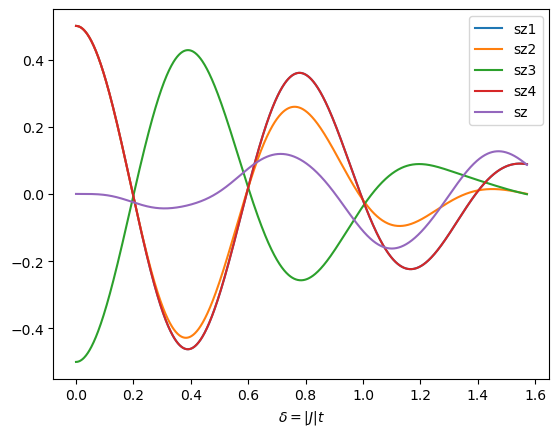

In [57]:
plt.plot(abs(J)*c_times,0.5*sz1_t)
plt.plot(abs(J)*c_times,0.5*sz2_t)
plt.plot(abs(J)*c_times,0.5*sz3_t)
plt.plot(abs(J)*c_times,0.5*sz4_t)
plt.plot(abs(J)*c_times,0.5*sz)
plt.legend(['sz1','sz2','sz3','sz4','sz'])
plt.xlabel(r'$\delta = |J|t$')
plt.show()

In [76]:
### Digital quantum simulation of the Heisenberg dimer model using qiskit
shots=8000

backend= QasmSimulator(shots=shots)  
sz1q_t = np.zeros(len(q_times))
sz2q_t = np.zeros(len(q_times))
sz3q_t = np.zeros(len(q_times))
sz4q_t = np.zeros(len(q_times))
szq=np.zeros(len(c_times))

num_qubits=4


# Run the quantum algorithm

n=20

for k, sim_t in enumerate(q_times):
    # my_expectation.convert((t * H).exp_i())
    # Prepare 
    #for i in range(0, num_qubits - 1):
        #qc.rzz(J*2*sim_t,i,i+1)
        #qc.rx(b*2*sim_t,i)
    #qc.rx(b*2*sim_t,num_qubits-1)
        # Initialize the circuit
    trott_qr = QuantumRegister(4)
    trott_qc = QuantumCircuit(trott_qr)
    trott_qc.x(2)
    
        # Append the Trotterization
    trott_steps = Ising_Trotter(num_qubits=4,J=-1,b=4,trotter_steps=n,t=sim_t)
        #trott_qc   = trott_qc.compose(trott_steps)
    trott_qc.append(trott_steps, [trott_qr[0], trott_qr[1], trott_qr[2], trott_qr[3]])
    
    
    # measure
    trott_qc.measure_all()
    
    # Run the quantum algorithm
    
    job = execute(trott_qc, backend)
    result = job.result()
    counts = result.get_counts()
    
    
    # Post processing of outcomes to get sz expectation values

    sz1q = 0
    sz2q = 0
    sz3q = 0
    sz4q = 0
    
    for key,value in counts.items():
        if key == '0000':
            sz1q += value
            sz2q += value
            sz3q += value
            sz4q += value
        elif key == '1000':
            sz1q += value
            sz2q += value
            sz3q += value
            sz4q -= value
        elif key == '0100':
            sz1q += value
            sz2q += value
            sz3q -= value
            sz4q += value
        elif key == '0010':
            sz1q += value
            sz2q -= value
            sz3q += value
            sz4q += value
        elif key == '0001':
            sz1q -= value
            sz2q += value
            sz3q += value
            sz4q += value
        elif key == '1100':
            sz1q += value
            sz2q += value
            sz3q -= value
            sz4q -= value
        elif key == '1010':
            sz1q += value
            sz2q -= value
            sz3q += value
            sz4q -= value
        elif key == '1001':
            sz1q -= value
            sz2q += value
            sz3q += value
            sz4q -= value
        elif key == '0110':
            sz1q += value
            sz2q -= value
            sz3q -= value
            sz4q += value
        elif key == '0011':
            sz1q -= value
            sz2q -= value
            sz3q += value
            sz4q += value
        elif key == '1110':
            sz1q += value
            sz2q -= value
            sz3q -= value
            sz4q -= value
        elif key == '0111':
            sz1q -= value
            sz2q -= value
            sz3q -= value
            sz4q += value
        elif key == '1011':
            sz1q -= value
            sz2q -= value
            sz3q += value
            sz4q -= value
        elif key == '1101':
            sz1q -= value
            sz2q += value
            sz3q -= value
            sz4q -= value
        elif key == '1001':
            sz1q -= value
            sz2q += value
            sz3q += value
            sz4q -= value
        elif key == '1111':
            sz1q -= value
            sz2q -= value
            sz3q -= value
            sz4q -= value

    sz1q_t[k] = sz1q/shots
    sz2q_t[k] = sz2q/shots
    sz3q_t[k] = sz3q/shots
    sz4q_t[k] = sz4q/shots
    szq[k]= sz1q_t[k]+sz2q_t[k]+sz3q_t[k]+sz4q_t[k]

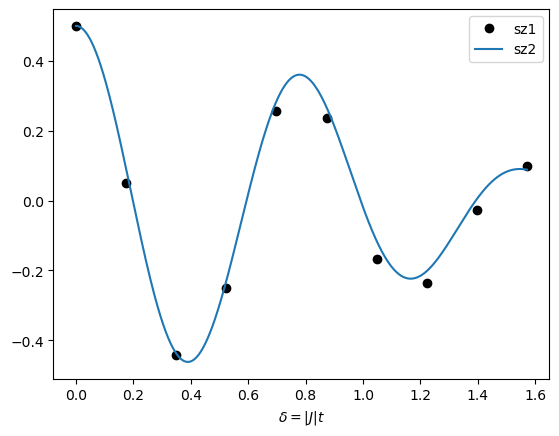

In [80]:
#plt.plot(abs(J)*q_times,0.5*sz1q_t,'rd')
#plt.plot(abs(J)*q_times,0.5*sz2q_t,'ko')
#plt.plot(abs(J)*q_times,0.5*sz3q_t,'rd')
plt.plot(abs(J)*q_times,0.5*sz4q_t,'ko')
#plt.plot(abs(J)*c_times,0.5*sz1_t)
#plt.plot(abs(J)*c_times,0.5*sz2_t)
#plt.plot(abs(J)*c_times,0.5*sz3_t)
plt.plot(abs(J)*c_times,0.5*sz4_t)
#plt.plot(abs(J)*c_times,0.5*sz)
plt.legend(['sz1','sz2','sz1q','sz2q'])
plt.xlabel(r'$\delta = |J|t$')
plt.show()